# DE Portfolio 2: Interpretation of Logistic Regression Results

This model uses the GTD (Global Terrorism Dataset) data. The dataset includes records of terrorist incidents and events starting 1970, including details such as targets, weapons, terrorist organizations or number of kills. The goal is to predict the probability to identify the terrorist group responsible for an event given that the attack happened in Europe and North America. This will be assesed based on the output being 1 or Yes (we have a name identifying the terrorist group) and 0 or No if the name is unknown. The results will be interpreted in regards to their distribution and evaluation metrics.

Dataset Source: [https://www.start.umd.edu/gtd/](https://www.start.umd.edu/gtd/)

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

### Load and Prepare Data

In [2]:
#Read data
df=pd.read_csv('Data_All.csv')
display(df)

C:\Users\maria\AppData\Local\Temp\ipykernel_16196\3165371317.py:2: DtypeWarning: Columns (4,31,33,37,54,61,62,63,76,79,90,92,94,96,114,115,121,135) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Data_All.csv')


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,1_txt
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214661,202106300023,2021,6,30,NaN,0,NaN,4,Afghanistan,6,...,"""Gunmen blow up power pylon in Parwan,"" Afghan...","""Provinces hit by blackout after power pylon d...",NaN,START Primary Collection,-9,-9,0,-9,NaN,Electricity
214662,202106300029,2021,6,30,06/30/2021,0,NaN,138,Myanmar,5,...,"""Spring Revolution Daily News for 16-30 June 2...",NaN,NaN,START Primary Collection,-9,-9,0,-9,NaN,Other Personnel
214663,202106300030,2021,6,30,NaN,1,2021-07-08,147,Nigeria,11,...,"""Boko Haram Releases Abducted Catholic Priest ...","""Kidnapped Maiduguri Catholic Priest regains f...","""ISWAP-Boko Haram Abduct Catholic Priest In Bo...",START Primary Collection,0,0,0,0,NaN,Religious Figure
214664,202106300038,2021,6,30,NaN,0,NaN,45,Colombia,3,...,"""Two dead and one wounded after clashes betwee...",NaN,NaN,START Primary Collection,0,0,0,0,NaN,NaN


#### Features selected
1. attacktype1_txt: categorical value defining the attack type of the event
2. targtype1_txt: (categorical value) explaining the types of targets attacked by the terrorist organisation
3. gname: The name of the terrorist organisation responsible for attack
4. property: If a property was attacked during the terrorist incident  (1 = Yes; 0 = No)
5. doubtterr: Binary value, explains whether there were doubts about the attack being organized by a terrorist group (1= Doubts, 0= No doubts)
6. region_txt: categorical value for regions where attacks took place
    - For this model we focus on Europe and North America

In [3]:
#Select relevant features
features=['region_txt', 'doubtterr', 'attacktype1_txt', 'targtype1_txt', 'gname', 'weaptype1_txt', 'property']
df=df[features]

#Filter dataframe so it includes only values from Europe and America
df = df[df['region_txt'].isin(['Western Europe', 'Eastern Europe', 'North America'])]

#Replace values called unknown or other with Nan and drop them
values_to_replace = ['Unknown', 'Other']
#An exception is made for terrorist group name since we need unknown values for our model
df.loc[:, df.columns != 'gname'] = df.loc[:, df.columns != 'gname'].replace(values_to_replace, pd.NA)
df=df.dropna()
display(df)

,region_txt,doubtterr,attacktype1_txt,targtype1_txt,gname,weaptype1_txt,property
3,Western Europe,0,Bombing/Explosion,Government (Diplomatic),Unknown,Explosives,1
5,North America,0,Armed Assault,Police,Black Nationalists,Firearms,1
7,North America,1,Bombing/Explosion,Utilities,Unknown,Explosives,1
8,North America,0,Facility/Infrastructure Attack,Military,New Year's Gang,Incendiary,1
9,North America,0,Facility/Infrastructure Attack,Government (General),New Year's Gang,Incendiary,1
...,...,...,...,...,...,...,...
214599,North America,0,Facility/Infrastructure Attack,Religious Figures/Institutions,Unknown,Incendiary,1
214635,North America,0,Facility/Infrastructure Attack,Religious Figures/Institutions,Unknown,Incendiary,1
214637,Western Europe,0,Facility/Infrastructure Attack,Government (General),Unknown,Incendiary,1
214652,North America,0,Facility/Infrastructure Attack,Religious Figures/Institutions,Unknown,Incendiary,1


In [4]:
#Define Y value
#If a terrorist group is known, Y is 1
Y= df['gname'].apply(lambda x:0 if x =='Unknown' else 1)

#Encode attack types
attack_type=pd.get_dummies(df['attacktype1_txt'], drop_first=True)
attack_matrix = attack_type.astype(int)

#Encode target types
target=['Private Citizens & Property', 'Journalists & Media', 'Tourists']
target_matrix=df['targtype1_txt'].apply(lambda x:1 if x in target else 0)

#Encode regions
region_type=pd.get_dummies(df['region_txt'], drop_first=True)
region_matrix = region_type.astype(int)

#Ensure numerical features are integers
doubt_attack=df['doubtterr'].astype(int)
property=df['property'].astype(int)

#Create design matrix
X = pd.concat([doubt_attack, target_matrix, attack_matrix, region_matrix, property], axis=1)



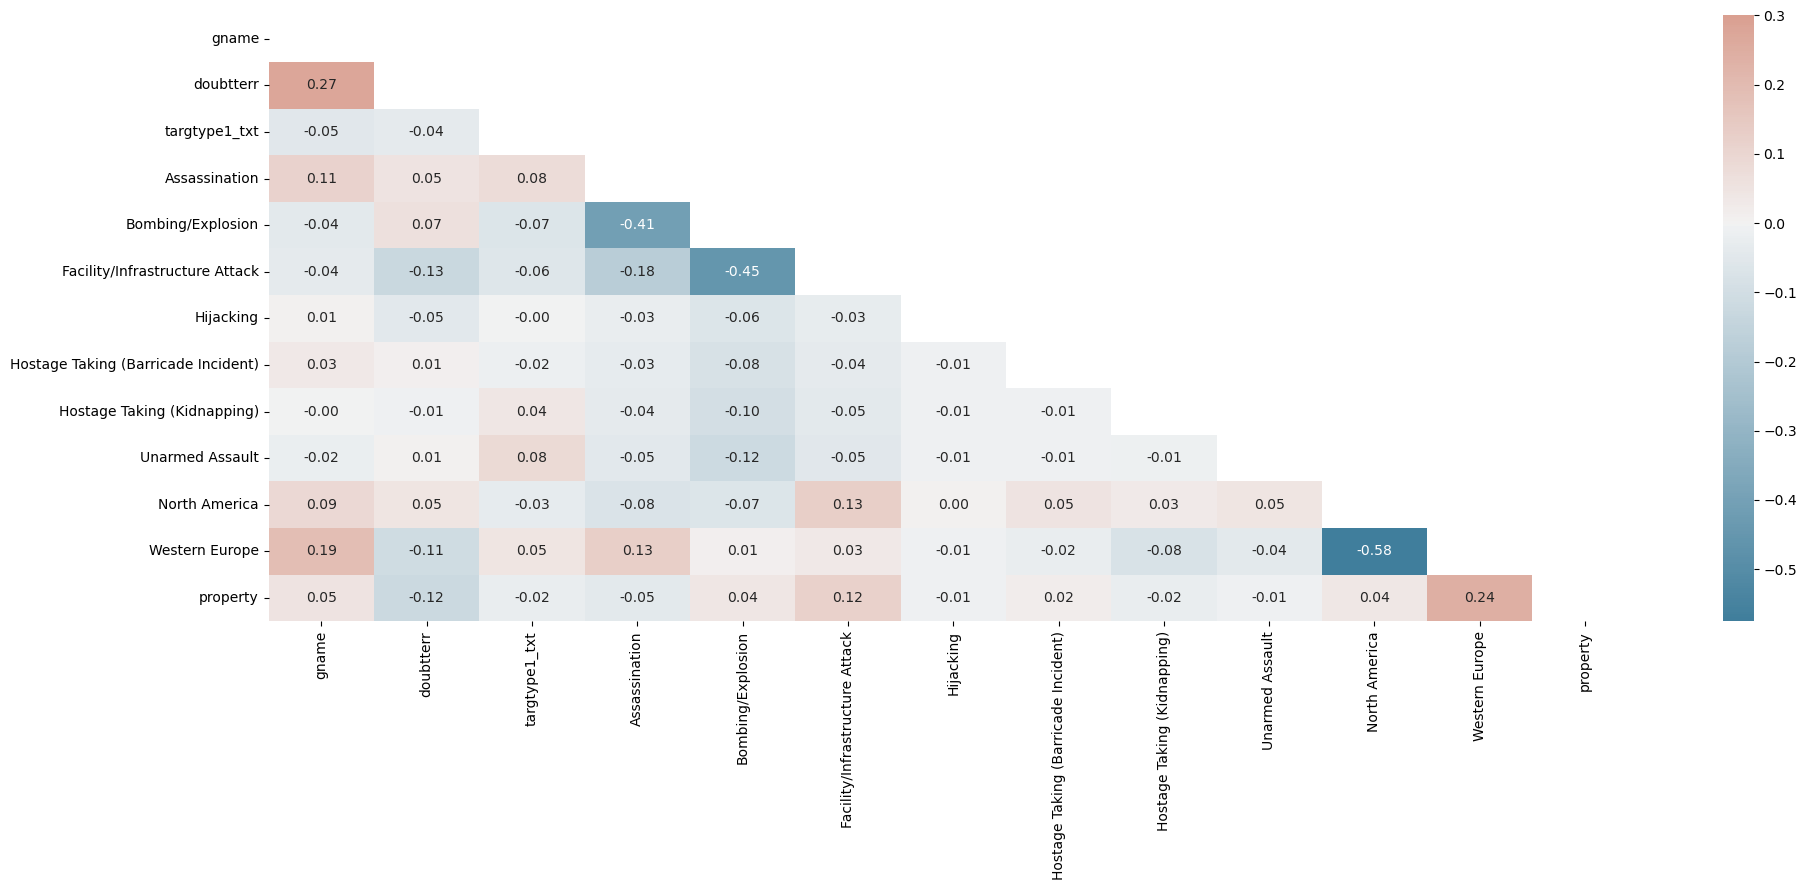

In [5]:
#Explore correlation between values
import seaborn as sns

#Add Y to X values as a way of examining correlation between features and outcome 
X['gname'] = Y

#Set Y as the first column
YX = X[['gname'] + [c for c in X.columns if c != 'gname']]

#Calculate correlations
corr = YX.corr()

#Plot correlation matrix
plt.figure(figsize=(20, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f", annot_kws={"size": 10})

plt.tight_layout()
plt.show()

### Fit Models

In [6]:
import statsmodels.api as sm 
import pandas as pd

#Define dependent and independent values
Y=Y
X = pd.concat([doubt_attack, target_matrix, attack_matrix, region_matrix, property], axis=1)

##### Homogenoeus Probability

In [7]:
#This model is fitted using just an intercept to asses the performance of the model if no other covariates are included.

#Add constant and fit the model with just the constant values
X_with_constant=sm.add_constant(X)
model=sm.Logit(Y, X_with_constant['const']).fit()

#Print summary
summary = model.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.660357
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                  gname   No. Observations:                24808
Model:                          Logit   Df Residuals:                    24807
Method:                           MLE   Df Model:                            0
Date:                Mon, 01 Apr 2024   Pseudo R-squ.:               1.557e-13
Time:                        13:43:38   Log-Likelihood:                -16382.
converged:                       True   LL-Null:                       -16382.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5208      0.013     39.663      0.000       0.495       0.547


In [8]:
#Get coefficients and covariance matrix
beta_coefficients= model.params #extracting coefficients
beta_cov= model.cov_params() #extracting covariance matrix

#Simulate log odds
base_log_odds =multivariate_normal.rvs(beta_coefficients, beta_cov, 1000)

#Simulate base odds
base_odds = np.exp(base_log_odds)

#Simulate base probability
base_prob = logistic_sigmoid(base_log_odds)

#Create array with all simulations
simulations = np.stack((base_log_odds, base_odds, base_prob), axis=1)

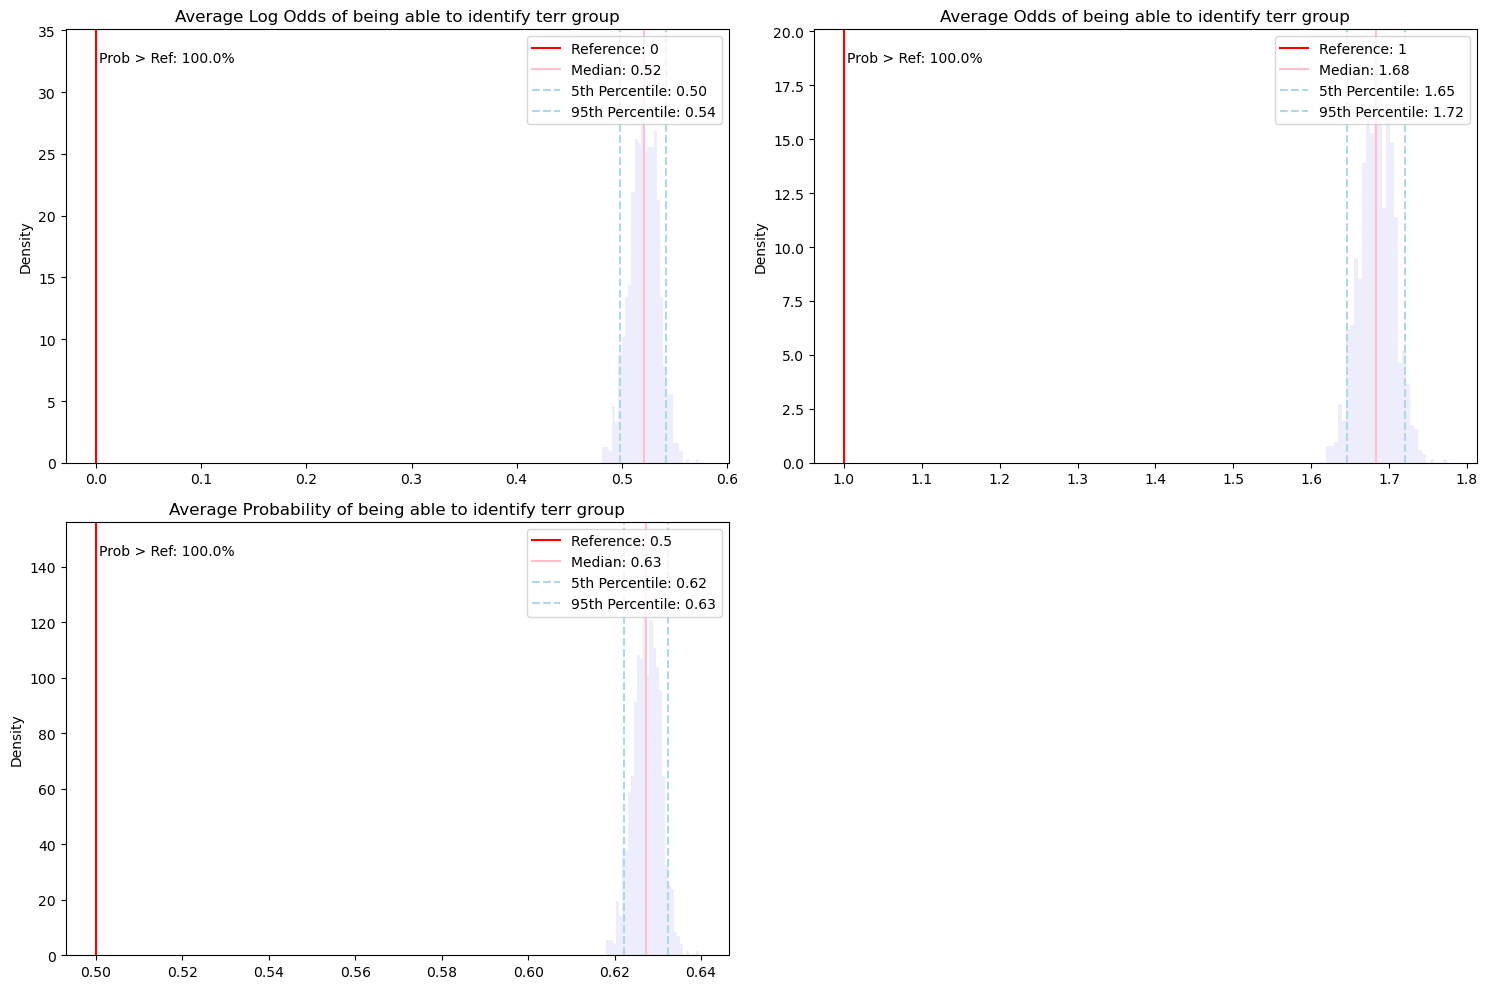

In [9]:
#Estimate statstics for constant model
medians = np.median(simulations, axis=0)  # median
low = np.percentile(simulations, 5, axis=0)  # lower quantile (interval)
up = np.percentile(simulations, 95, axis=0)  # upper quantile (interval)
references = [0, 1, 0.5]  # Reference values for simulated log-odds, odds, and probability
positive = [np.mean(simulations[:, i] > references[i]) for i in range(3)]

#Define the name for each plot
col_names = ['Log Odds', 'Odds', 'Probability']

# Plot histograms
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for i in range(len(col_names)):
    ax = axs[i]
    ax.hist(simulations[:, i], bins=30, density=True, alpha=0.7, color='lavender')  # Change color here

    # Add vertical lines for median and interval
    ax.axvline(references[i], color='red', linestyle='-', label=f'Reference: {references[i]}')
    ax.axvline(medians[i], color='pink', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(low[i], color='lightblue', linestyle='--', label=f'5th Percentile: {low[i]:.2f}')
    ax.axvline(up[i], color='lightblue', linestyle='--', label=f'95th Percentile: {up[i]:.2f}')
    ax.text(0.05, 0.95, f'Prob > Ref: {positive[i]*100:.1f}%', transform=ax.transAxes, verticalalignment='top')

    ax.set_title(f'Average {col_names[i]} of being able to identify terr group')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

# Hide empty subplot
if len(col_names) % 2 != 0:
    axs[-1].axis('off')

plt.tight_layout()
plt.show()


##### Interpretation
These plots show the average probability of being able to identify a terorrist group on 3 different scales. These distributions are based on a model using only a constant and no other features. The first plot shows a postive median of 0.52, explaining that on avergae it is more likely to know the name of a terrorist organisation responsible for an attack. The distribution is quite narrow meaning that there is a somewhat high degree of certainity. By taking the exponential function out of the log odds we can get the odds of knowing the perpetrator's name. With a value high over 1, it is clear that it is more likely to know the names. The last plot shows us the probabilities of knowing the names, ranging between 62 and 64% probability. The distribution is by 0.01 meaning there is high certainity and significance that the it is more likely to know the names than not to.

##### Model Assesmnet

In [10]:
#Calculate AIC to evaluate the 'goodness' of the model
import statsmodels.api as sm
AIC = model.aic
print(f"AIC Score for intercept only model is:", AIC)

AIC Score for intercept only model is: 32766.28680223301


##### Heterogeneous Probability with Binary Covariate

In [11]:
#Fit model with binary values
model=sm.Logit(Y, X_with_constant[['const', 'doubtterr', 'property', 'targtype1_txt']]).fit()

#Print model summary
summary=model.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.618816
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  gname   No. Observations:                24808
Model:                          Logit   Df Residuals:                    24804
Method:                           MLE   Df Model:                            3
Date:                Mon, 01 Apr 2024   Pseudo R-squ.:                 0.06291
Time:                        13:43:39   Log-Likelihood:                -15352.
converged:                       True   LL-Null:                       -16382.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7312      0.016     45.666      0.000       0.700       0.763
doubtterr         0.

In [12]:
#Get coefficietns and covariance matrix
beta_coef=model.params
beta_cov_m= model.cov_params()

#Get coefficients from posterior distribution 
beta_simulations_log= multivariate_normal.rvs(beta_coef, beta_cov_m, 1000)

#Get odds
odds=np.exp(beta_simulations_log)

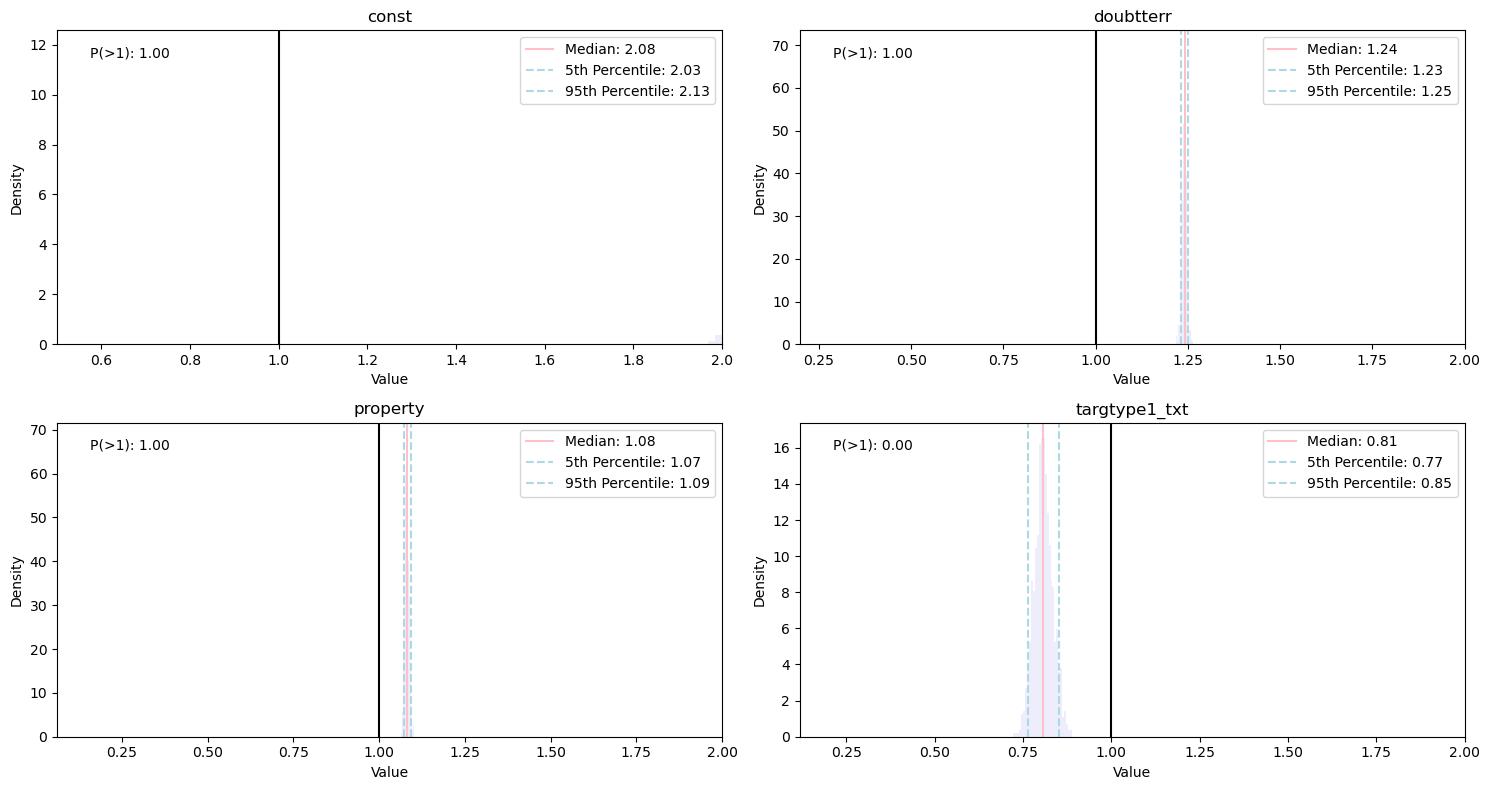

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate statistics for constant and attack coefficients
median_s = np.median(odds, axis=0)  # median
lower_p = np.percentile(odds, 5, axis=0)  # lower quantile (interval)
upper_p = np.percentile(odds, 95, axis=0)  # upper quantile (interval)
prob_of_positive = np.mean(odds > 1, axis=0)  # probability of odds to be above 1 (positive)

# Set column names
column_names = ['const', 'doubtterr', 'property', 'targtype1_txt']

# Create plots for each coefficient
num_rows = (beta_simulations_log.shape[1] + 1) // 2
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(beta_simulations_log.shape[1]):
    ax = axs[i]
    ax.hist(odds[:, i], bins=30, density=True, alpha=0.7, color='lavender')

    # Add vertical lines for 0
    ax.axvline(1, color='black', linestyle='-')

    # Add vertical lines for median and interval
    ax.axvline(median_s[i], color='pink', linestyle='-', label=f'Median: {median_s[i]:.2f}')
    ax.axvline(lower_p[i], color='lightblue', linestyle='--', label=f'5th Percentile: {lower_p[i]:.2f}')
    ax.axvline(upper_p[i], color='lightblue', linestyle='--', label=f'95th Percentile: {upper_p[i]:.2f}')

    # Add text annotation for probability above 1
    ax.text(0.05, 0.95, f'P(>1): {prob_of_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top',
            fontsize=10)

    ax.set_title(f'{column_names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')
    ax.set_xlim(left=min(0.5, abs(beta_simulations_log[:, i]).min()), right=max(2, abs(beta_simulations_log[:, i]).max()))

# Hide empty subplot
if beta_simulations_log.shape[1] % 2 != 0:
    axs[-1].axis('off')

plt.tight_layout()
plt.show()


##### Interpretation
These plots show the odds of knowing the name of the terrorist group given a certain feature. The constant (or intercept) plot shows the odds of knowing the group when there are no doubts about the attack being a terrorist event, a property or targets were not attacked. The median is very high, hence why not in the graph, meaning that the odds are high. If there is a doubt about the event being a terrorist attack (2nd plot) or property was attacked (3rd plot) median decreases but still over 1. However, when we include different categories included in target type, the scores decrease even more but still have high odds of knowing the name of the organisation. All plots have a narrow interval meaning there is high certainity about these odds.

##### Model Assesment

In [14]:
#Calculate AIC to evaluate the 'goodness' of the model
import statsmodels.api as sm
AIC = model.aic
print(f"AIC Score for binary only model is:", AIC)

AIC Score for binary only model is: 30711.159758455473


#### Complex Heterogeneous Probability (all covariates)

In [15]:
#Fit model with all features and interactions
model=sm.Logit(Y, X_with_constant).fit()

# Get summary results
summary=model.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.557286
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  gname   No. Observations:                24808
Model:                          Logit   Df Residuals:                    24795
Method:                           MLE   Df Model:                           12
Date:                Mon, 01 Apr 2024   Pseudo R-squ.:                  0.1561
Time:                        13:43:40   Log-Likelihood:                -13825.
converged:                       True   LL-Null:                       -16382.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.4570      0.046 

In [16]:
#Extract coefficients and covariance matrix
beta_mean =model.params
beta_c =model.cov_params()

#Simulate beta cpefficients
beta_simulations=multivariate_normal.rvs(beta_mean, beta_c, 1000)

#Get base odds for the coefficients
odds=np.exp(beta_simulations)

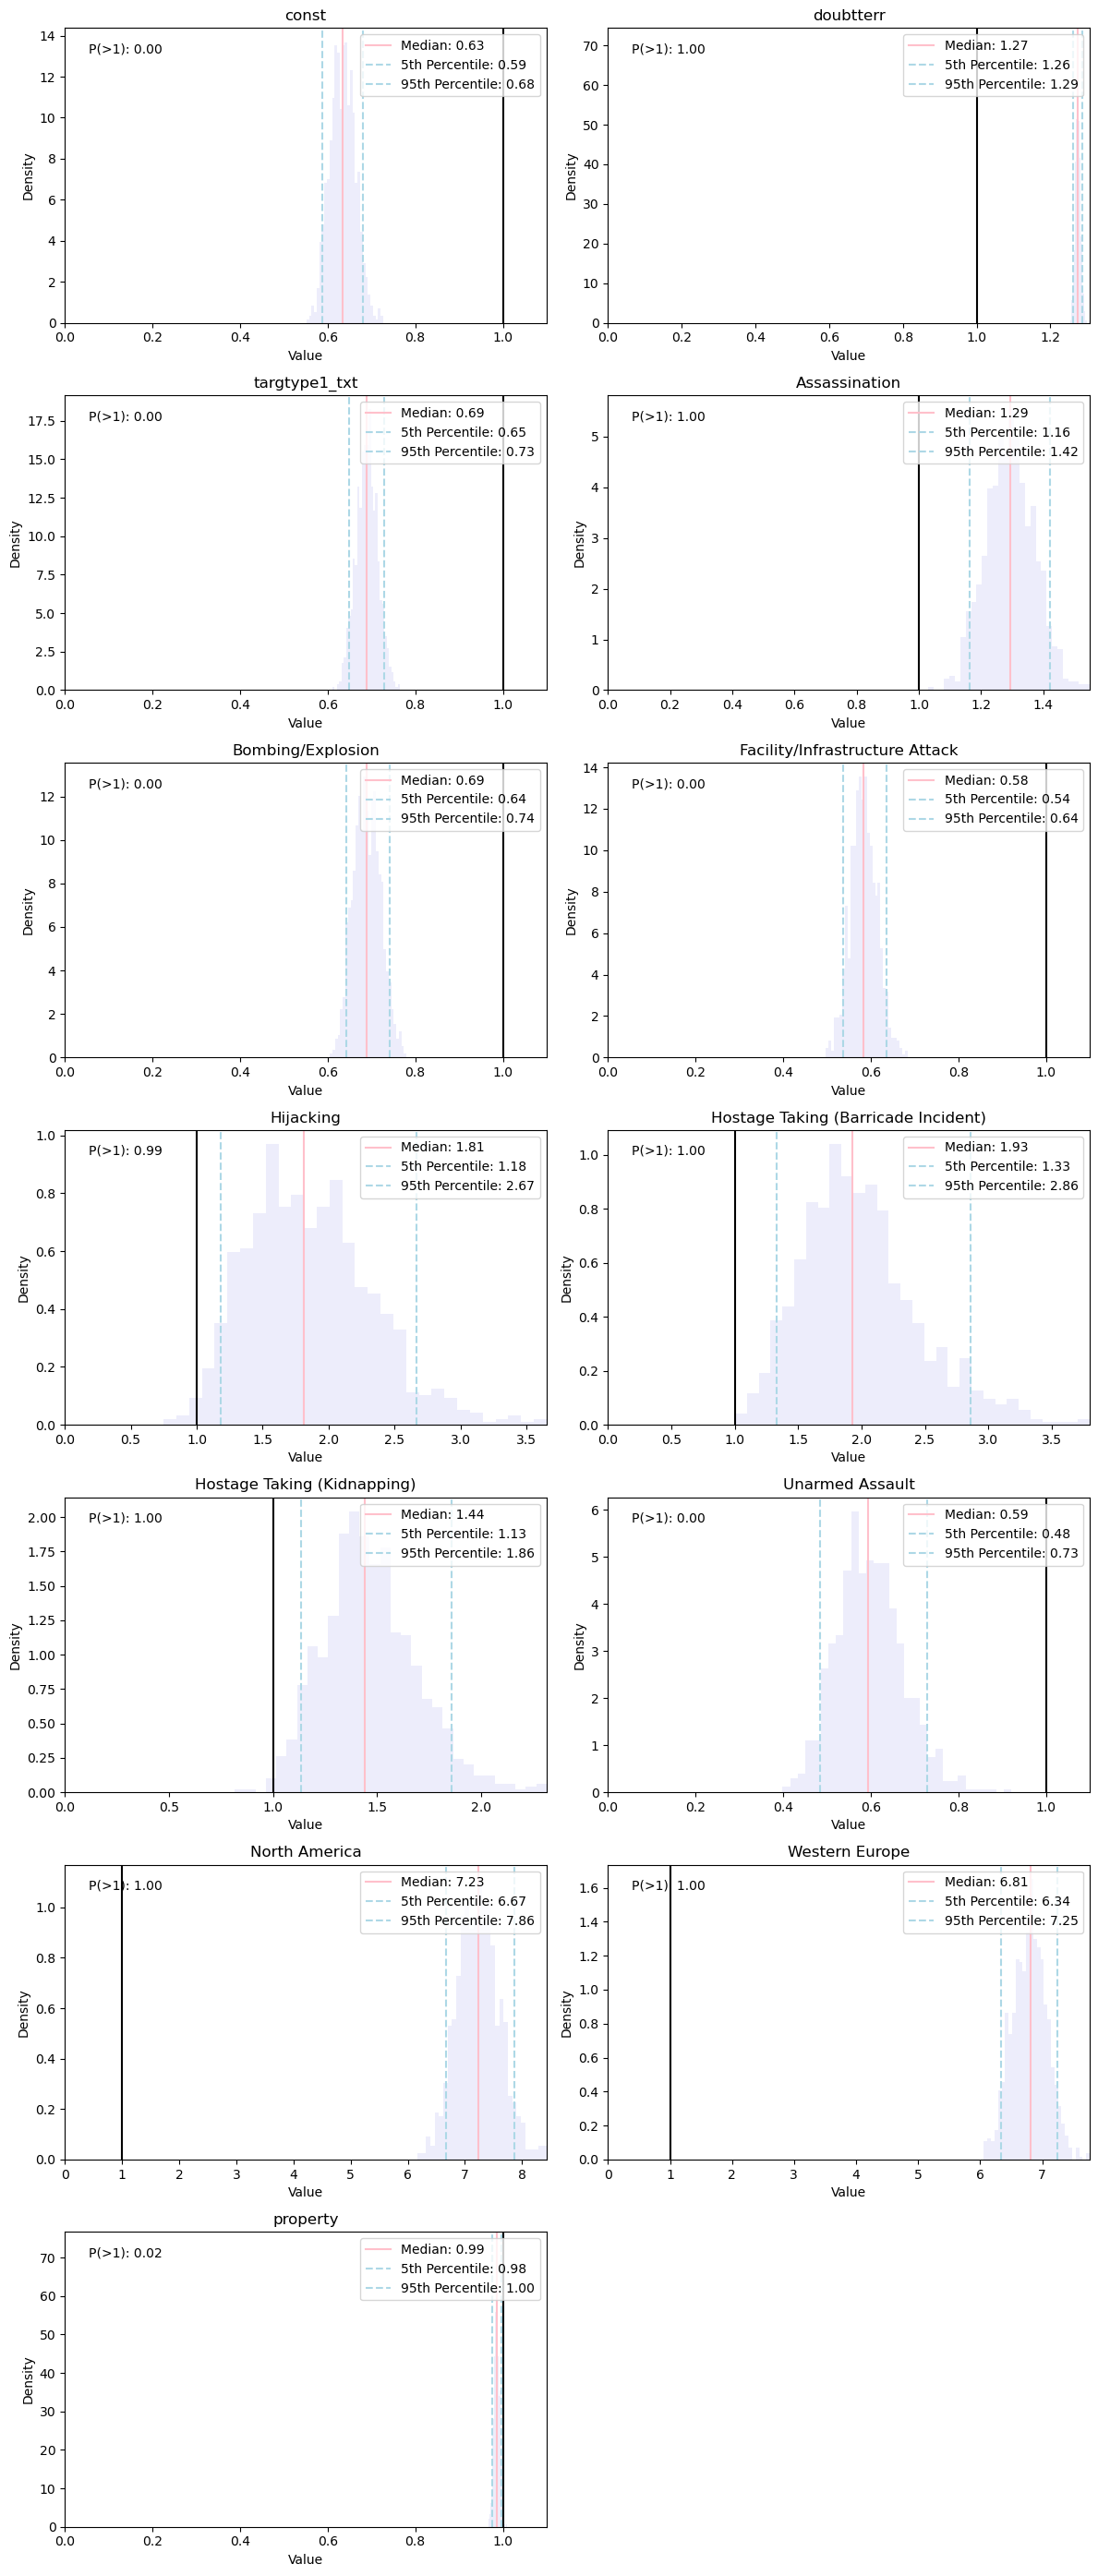

In [17]:
# Calculate median, interval, and probability of being positive for coefficients
median = np.median(odds, axis=0)
lower = np.percentile(odds, 5, axis=0)
upper = np.percentile(odds, 95, axis=0)
probability = np.mean(odds > 1, axis=0)

#Set plot names for coefficients based on X dataframe columns
names = X_with_constant.columns

#Calculate how many rows and columns are needed for the plots
num_plots = beta_simulations.shape[1]
num_cols = 2
num_rows = (num_plots + 1) // num_cols

#Define figure size to improve visibility
fig_width = 12
fig_height = num_rows * 4

#Plot
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
axs = axs.flatten()

for i in range(num_plots):
    ax = axs[i]
    ax.hist(odds[:, i], bins=30, density=True, alpha=0.7, color='lavender')

    # Add vertical lines for 0
    ax.axvline(1, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(median[i], color='pink', linestyle='-', label=f'Median: {median[i]:.2f}')
    ax.axvline(lower[i], color='lightblue', linestyle='--', label=f'5th Percentile: {lower[i]:.2f}')
    ax.axvline(upper[i], color='lightblue', linestyle='--', label=f'95th Percentile: {upper[i]:.2f}')
    
    # Add text annotation for probability above 1
    ax.text(0.05, 0.95, f'P(>1): {probability[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    ax.set_title(f'{names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 1 and starts at 0
    ax.set_xlim(left=0, right=max(1.1, abs(odds[:, i]).max())) 
    
# Hide empty subplot
if num_plots % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()




##### Interpretation
These plots show the distribution of odds for a model that uses all covariates. The intercept plot, which is also considered a baseline, shows the odds when no attack happened, there is no doubt about the incident being terrorist, the attack type is different from the values presented above (based on the remaining values it can armed assault, vehicle attack) and when the targets are anything but civillians and properties. In this case, the odds indicate that we are 0.63 times likely to know the name of the perpetrator. Doubt and property attackks are both plots with high certainty, doubt being more postive than property and indicating that having doubt is statistically certain to lead in knowing the group name. The distributions across different attack types vary, having positive and statistically significant odds for Hostage Taking, Assasination or Hijacking. With the density being almost entirly over 1, we can assume that these attacks are likely to lead to knwoing the group name. A similar situaion can be seen in terms of regions, with both regions being above 1 and having narrow distributions. A significant decrease in odds appears for target type and the rest of the attacks specified.

##### Model Assesment

In [18]:
#Calculate AIC to evaluate the 'goodness' of the model
import statsmodels.api as sm
AIC = model.aic
print(f"AIC Score for heterogeneous model is:", AIC)

AIC Score for heterogeneous model is: 27676.3005322583
